<a href="https://colab.research.google.com/github/Adjideuyeuy22/DL_TM4/blob/main/DL_TM4/epoch100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'asl-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F177084%2F399170%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240504%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240504T085605Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1373e28c696a6f5aa2153b89d0bd8c02f12b451241057b5454a327b1ef492e1406edc27b746acb62a0ef4399c85bba7bc865e5429c54f946771c4165b8fe9c945c5800b53ff4d45ee7ea37ec3d5ec95eeb1b911d5119db6b7fce08a8ef4fae827d02561a601bb1a47946e0d2a6652681cd8d7882a0be7f25ef6e2d8405cc9dbd82938b8c87fadb39fe3ac8e3b2eb297e295219c045dd86e1b93d91c48de675c759c506a771060489f79c329a2476f91c42e967a5689a6408deb0cc2003790fb6152cdd7bed7b4134bc719cdf69828d29e0e7c962e71dff0c0ac02428c9416312ac9bddd9c40e2e31ed5afc5063553e91aa8d79329615a9efd995e07028acb1de'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 59642568 bytes downloaded
Downloaded and uncompressed: asl-dataset
Data source import complete.


In [87]:
import cv2
import random
import os
import keras
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Dropout,
    Input,
    Activation,
    concatenate,
)

In [88]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "/kaggle/input/asl-dataset/asl_dataset/"

# Dictionary to save our 12 classes
categories = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
    10: "a",
    11: "b",
    12: "c",
    13: "d",
    14: "e",
    15: "f",
    16: "g",
    17: "h",
    18: "i",
    19: "j",
    20: "k",
    21: "l",
    22: "m",
    23: "n",
    24: "o",
    25: "p",
    26: "q",
    27: "r",
    28: "s",
    29: "t",
    30: "u",
    31: "v",
    32: "w",
    33: "x",
    34: "y",
    35: "z",
}

In [89]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(
        lambda x: x[re.search("_", x).start() + 1 : re.search("_", x).start() + 2]
        + "/"
        + x
    )
    return df


# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})
df = add_class_name_prefix(df, "filename")

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print("number of elements = ", len(df))
df

number of elements =  2515


,filename,category
0,2/hand1_2_right_seg_5_cropped.jpeg,2
1,c/hand1_c_bot_seg_1_cropped.jpeg,12
2,f/hand2_f_right_seg_4_cropped.jpeg,15
3,z/hand2_z_top_seg_4_cropped.jpeg,35
4,f/hand1_f_bot_seg_3_cropped.jpeg,15
...,...,...
2510,3/hand5_3_bot_seg_3_cropped.jpeg,3
2511,f/hand5_f_bot_seg_2_cropped.jpeg,15
2512,k/hand1_k_dif_seg_1_cropped.jpeg,20
2513,8/hand1_8_left_seg_1_cropped.jpeg,8


h/hand2_h_right_seg_2_cropped.jpeg


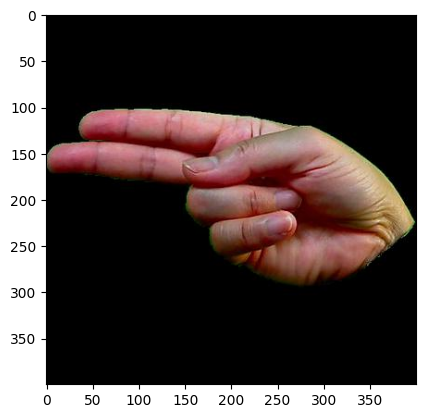

In [90]:
random_row = random.randint(0, len(df) - 1)
sample = df.iloc[random_row]
randomimage = keras.utils.load_img(base_path + sample["filename"])
print(sample["filename"])
plt.imshow(randomimage)

Text(0.5, 1.02, 'Count of images per class')

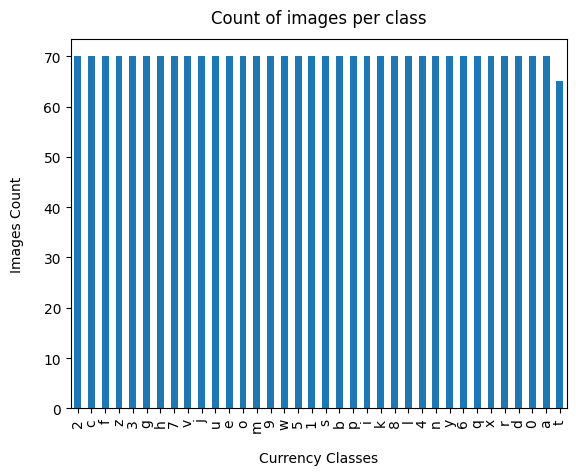

In [91]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization["category"] = df_visualization["category"].apply(
    lambda x: categories[x]
)

df_visualization["category"].value_counts().plot.bar(x="count", y="category")

plt.xlabel("Currency Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02)

In [92]:
from sklearn.model_selection import train_test_split

# Change the categories from numbers to names
df["category"] = df["category"].replace(categories)

# Split the data into training, validation, and testing sets (70%, 10%, 10%)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
validate_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Reset index for all dataframes
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Print sizes of each set
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
total_test = test_df.shape[0]
print(
    "train size =", total_train,
    "validate size =", total_validate,
    "test size =", total_test
)


train size = 1760 validate size = 377 test size = 378


In [93]:
batch_size = 32

datagen = image.ImageDataGenerator(
    ###  Augmentation Start  ###
    rescale=1.0 / 255,
    #     brightness_range=[0.5, 1.5],
    #     rotation_range=30,
    #     shear_range=0.1,
    #     zoom_range=0.3,
    #     horizontal_flip=True,
    #     vertical_flip = True,
    #     width_shift_range=0.2,
    #     height_shift_range=0.2
    ##  Augmentation End  ###
)

train_generator = datagen.flow_from_dataframe(
    train_df,
    base_path,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size,
)

validation_generator = datagen.flow_from_dataframe(
    validate_df,
    base_path,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size,
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    base_path,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
)

Found 1760 validated image filenames belonging to 36 classes.
Found 377 validated image filenames belonging to 36 classes.
Found 378 validated image filenames belonging to 36 classes.


In [94]:
bnmomemtum = 0.9


def fire_module(x, squeeze, expand):
    y = Conv2D(filters=squeeze, kernel_size=1, activation="relu", padding="same")(x)
    y = BatchNormalization(momentum=bnmomemtum)(y)
    y1 = Conv2D(filters=expand // 2, kernel_size=1, activation="relu", padding="same")(y)
    y1 = BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = Conv2D(filters=expand // 2, kernel_size=3, activation="relu", padding="same")(y)
    y3 = BatchNormalization(momentum=bnmomemtum)(y3)
    return concatenate([y1, y3])


def SqueezeNet(input_shape, num_classes):
    input = Input(shape=input_shape)
    y = Conv2D(kernel_size=7, filters=96, strides=2, padding="same", activation="relu")(input)
    y = BatchNormalization(momentum=bnmomemtum)(y)
    y = MaxPooling2D(pool_size=3, strides=2)(y)
    y = fire_module(y, 16, 64)
    y = fire_module(y, 16, 64)
    y = fire_module(y, 32, 128)
    y = MaxPooling2D(pool_size=3, strides=2)(y)
    y = fire_module(y, 32, 128)
    y = fire_module(y, 48, 192)
    y = fire_module(y, 48, 192)
    y = fire_module(y, 64, 256)
    y = MaxPooling2D(pool_size=2)(y)
    y = fire_module(y, 64, 256)
    y = Conv2D(kernel_size=1, filters=1000, strides=1, padding="same", activation="relu")(y)
    y = GlobalAveragePooling2D()(y)
    y = Dense(num_classes, activation="softmax")(y)
    model = Model(input, y)
    return model

In [95]:
model = SqueezeNet(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), num_classes=len(categories)
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_130 (Conv2D)         (None, 112, 112, 96)         14208     ['input_6[0][0]']             
                                                                                                  
 batch_normalization_125 (B  (None, 112, 112, 96)         384       ['conv2d_130[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 max_pooling2d_15 (MaxPooli  (None, 55, 55, 96)           0         ['batch_normalization_12

In [96]:
# model = Sequential()
# model.add(
#     Conv2D(
#         filters=32,
#         kernel_size=7,
#         activation="relu",
#         padding="same",
#         input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
#     )
# )
# # model.add(Conv2D(filters=16, kernel_size=3, padding="same", activation="relu"))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"))
# # model.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.25))

# model.add(Conv2D(filters=128, kernel_size=5, padding="same", activation="relu"))
# # model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.25))

# model.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
# # model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.25))

# model.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
# # model.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(4096, activation="relu"))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.5))
# model.add(Dense(4096, activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(len(categories), activation="softmax"))

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# model.summary()

In [97]:
EPOCHS = 100
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=[learning_rate_reduction, early_stop],
)

Epoch 1/100
55/55 [==============================] - 21s 125ms/step - loss: 2.5147 - accuracy: 0.2511 - val_loss: 9.2019 - val_accuracy: 0.0767 - lr: 0.0010
Epoch 2/100
55/55 [==============================] - 6s 107ms/step - loss: 1.1186 - accuracy: 0.6307 - val_loss: 4.5573 - val_accuracy: 0.2614 - lr: 0.0010
Epoch 3/100
55/55 [==============================] - 7s 122ms/step - loss: 0.7027 - accuracy: 0.7551 - val_loss: 5.1958 - val_accuracy: 0.2159 - lr: 0.0010
Epoch 4/100
55/55 [==============================] - 6s 108ms/step - loss: 0.5211 - accuracy: 0.8278 - val_loss: 3.3545 - val_accuracy: 0.3665 - lr: 0.0010
Epoch 5/100
55/55 [==============================] - 6s 111ms/step - loss: 0.3765 - accuracy: 0.8597 - val_loss: 0.3702 - val_accuracy: 0.8864 - lr: 0.0010
Epoch 6/100
55/55 [==============================] - 7s 118ms/step - loss: 0.2867 - accuracy: 0.8977 - val_loss: 0.9854 - val_accuracy: 0.6676 - lr: 0.0010
Epoch 7/100
55/55 [==============================] - 7s 119ms/s

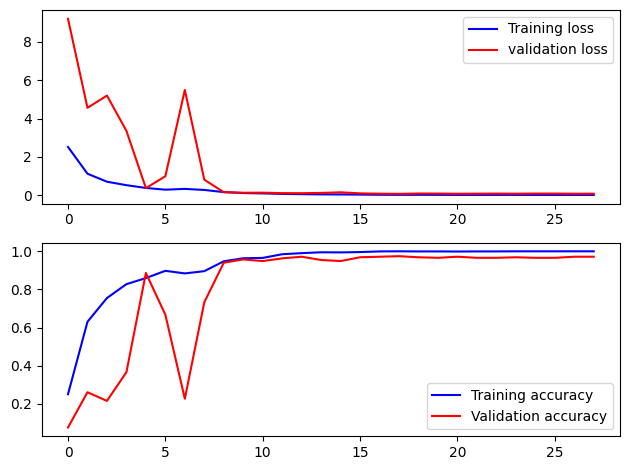

In [98]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history["loss"], color="b", label="Training loss")
ax1.plot(history.history["val_loss"], color="r", label="validation loss")
ax1.legend()

ax2.plot(history.history["accuracy"], color="b", label="Training accuracy")
ax2.plot(history.history["val_accuracy"], color="r", label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [99]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)
print("Accuracy on test set = ", round((accuracy * 100), 2), "% ")

<ipython-input-99-3bec3a93550b>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


Accuracy on test set =  97.35 % 


In [100]:
gen_label_map = test_generator.class_indices
gen_label_map = dict((v, k) for k, v in gen_label_map.items())
print(gen_label_map)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'a', 11: 'b', 12: 'c', 13: 'd', 14: 'e', 15: 'f', 16: 'g', 17: 'h', 18: 'i', 19: 'j', 20: 'k', 21: 'l', 22: 'm', 23: 'n', 24: 'o', 25: 'p', 26: 'q', 27: 'r', 28: 's', 29: 't', 30: 'u', 31: 'v', 32: 'w', 33: 'x', 34: 'y', 35: 'z'}


In [101]:
preds = model.predict(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df["category"].to_numpy()

print(classification_report(labels, preds))

378/378 [==============================] - 4s 10ms/step
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       0.90      0.90      0.90        10
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00         9
           6       1.00      0.92      0.96        12
           7       1.00      1.00      1.00        14
           8       0.91      1.00      0.95        10
           9       1.00      0.90      0.95        10
           a       1.00      1.00      1.00         8
           b       1.00      1.00      1.00        10
           c       1.00      1.00      1.00        10
           d       1.00      1.00      1.00         8
           e       1.00      1.00      1.00         5
           f       1.00      1.00      1.00         8
           g       1.00  

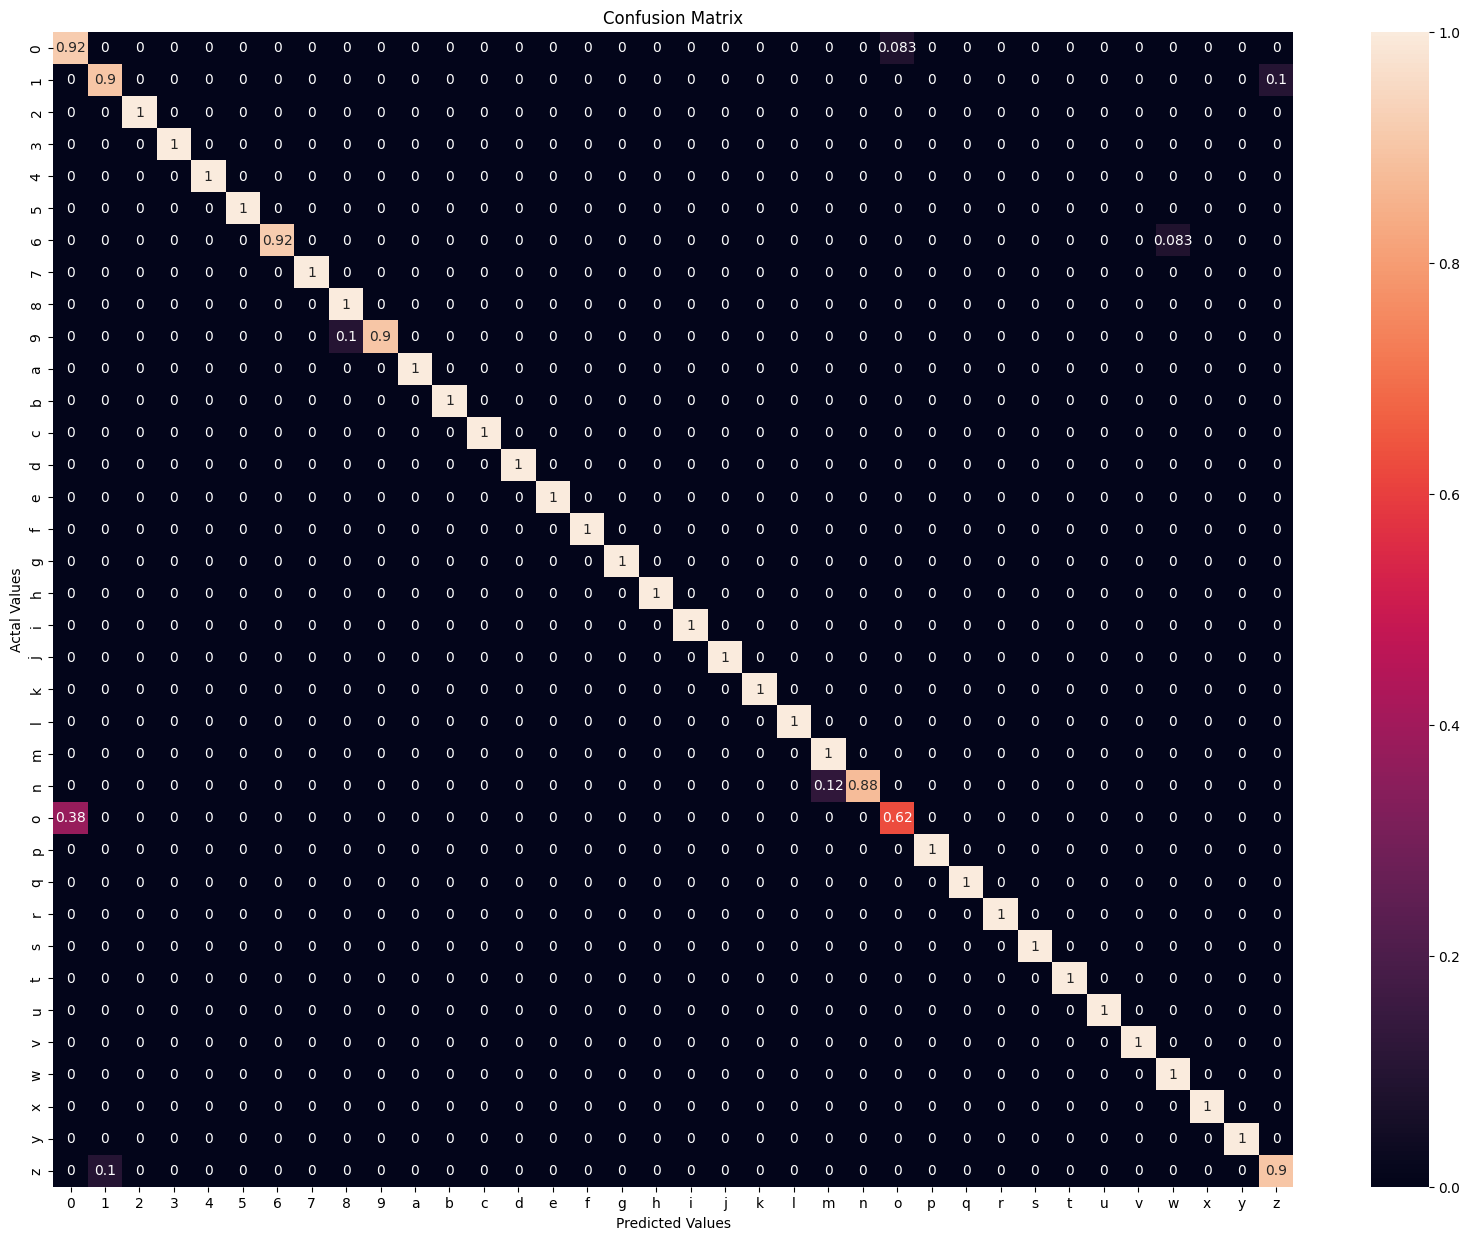

In [102]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_matrix = metrics.confusion_matrix(labels, preds, normalize="true")
cm_df = pd.DataFrame(
    confusion_matrix, index=categories.values(), columns=categories.values()
)
plt.figure(figsize=(20, 15))
sns.heatmap(cm_df, annot=True)
plt.title("Confusion Matrix")
plt.ylabel("Actal Values")
plt.xlabel("Predicted Values")
plt.show()